In [1]:
import sys
import numpy as np
import pandas as pd
import os
import re
import fabio
import xarray as xr
import pickle
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib import font_manager
from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from adjustText import adjust_text
from tqdm import tqdm

from GIWAXSDataProcessor import GIWAXSDataProcessor
from CrystalIndexingAnalyzer import CrystalIndexingAnalyzer

C:\Users\Phong\anaconda3\envs\DopantModeling-dev\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'arial'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.linewidth'] = 2

# Load the raw .tif file, orient it and make sure the beam center is as intended

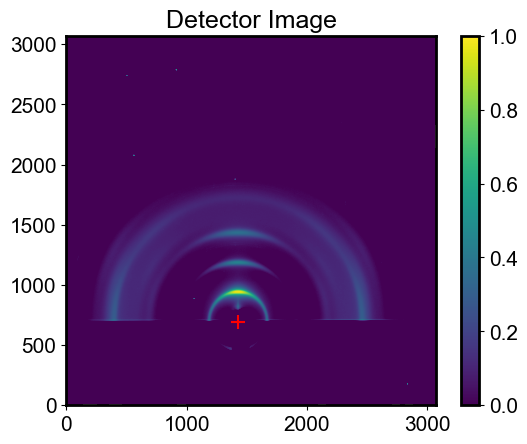

In [12]:
processor = GIWAXSDataProcessor()

file = r'.\example_data\EPEN_0p1deg_120s_08241133_0001.tif'

px_size_x, px_size_y = 0.073242, 0.073242
bc_x, bc_y = 1427.66, 2381.05
R = 289.52 # mm
xray_en= 12.7 # keV
q_range = 2 # inv A
q_res = 0.001 # inv A
incidence = 0.1 # degrees

image = np.flipud(fabio.open(file).data)
# Auto masking is optional - additional info is included in the source code
masked_image, mask = processor.automask(image, threshold_value=2)

plt.imshow(masked_image, origin = 'lower', norm=LogNorm(np.nanpercentile(image, 80)))
plt.scatter(bc_x, image.shape[1] - bc_y, color='red', s=100, marker='+', label='Beam Center')
plt.colorbar()
plt.title('Detector Image')
plt.show()

# Map the detector image to q-space and apply intensity corrections

In [4]:
qzqxy = processor.img_to_qzqxy(masked_image, bc_x, bc_y, R, incidence, px_size_x, px_size_y, q_range, q_res, xray_en)

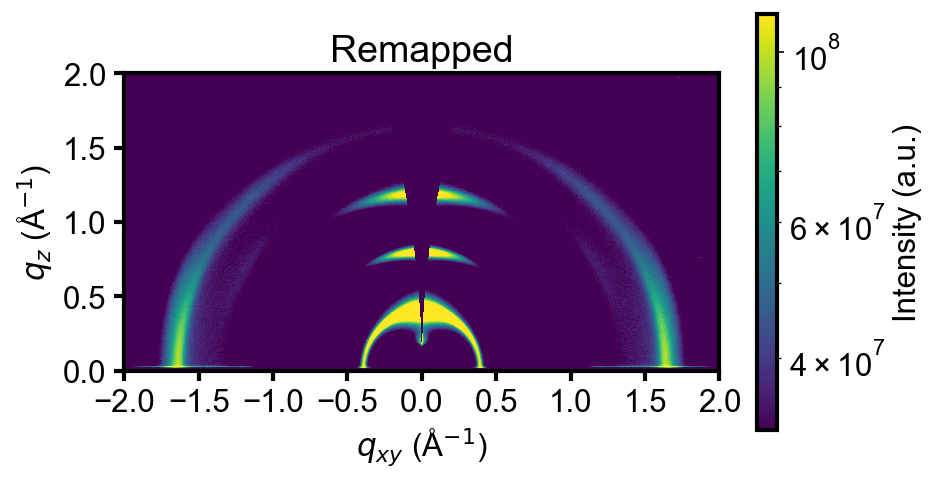

In [14]:
fig, ax = processor.plot_qzqxy(qzqxy, cmap='viridis')
plt.title('Remapped')
plt.show()

# Cake by converting to polar coordinates and apply sin(chi) correction

In [ ]:
chiq, corrected_chiq = processor.cake_and_corr(qzqxy)

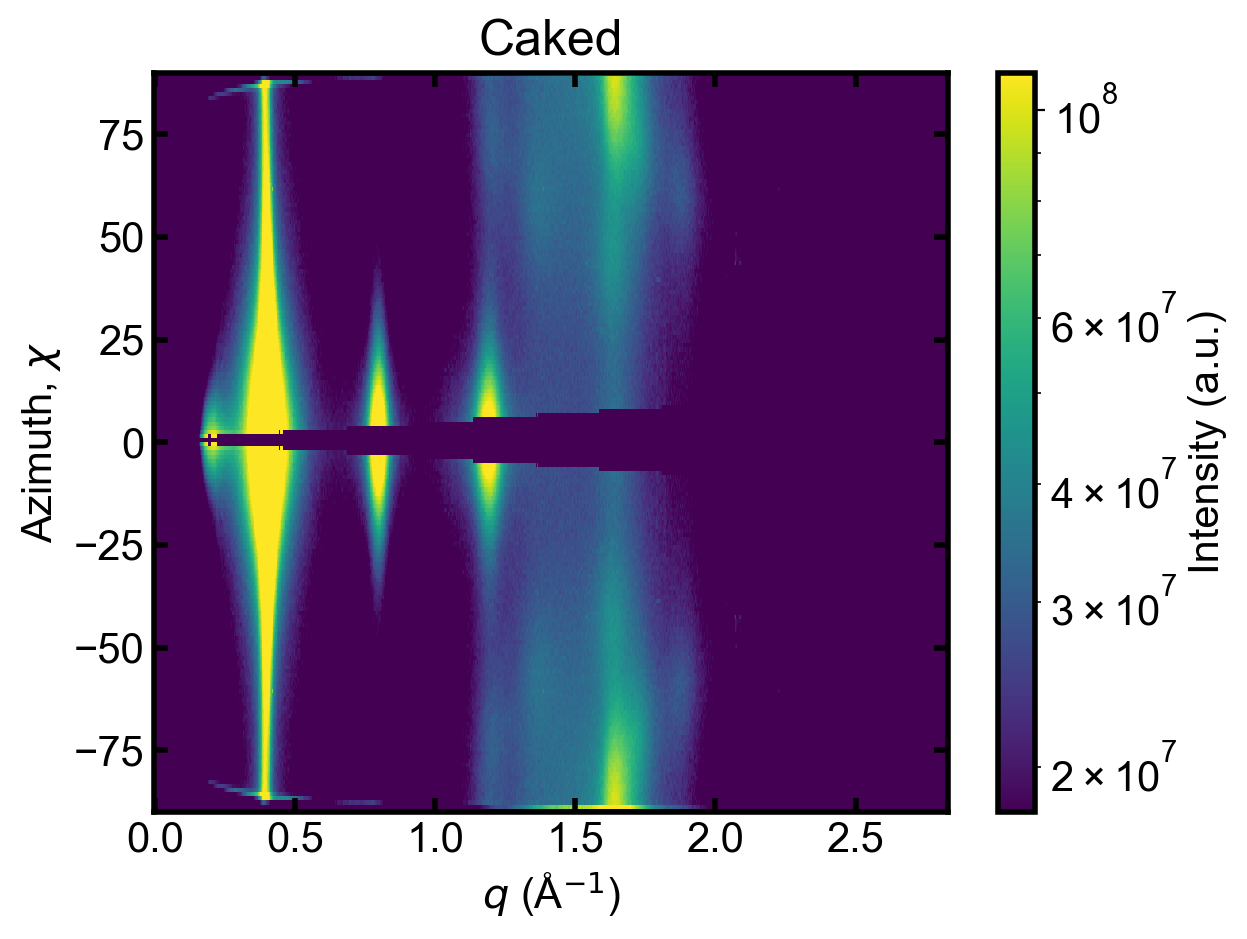

In [15]:
fig, ax = processor.plot_chiq(chiq, cmap='viridis')
plt.title('Caked')
plt.show()

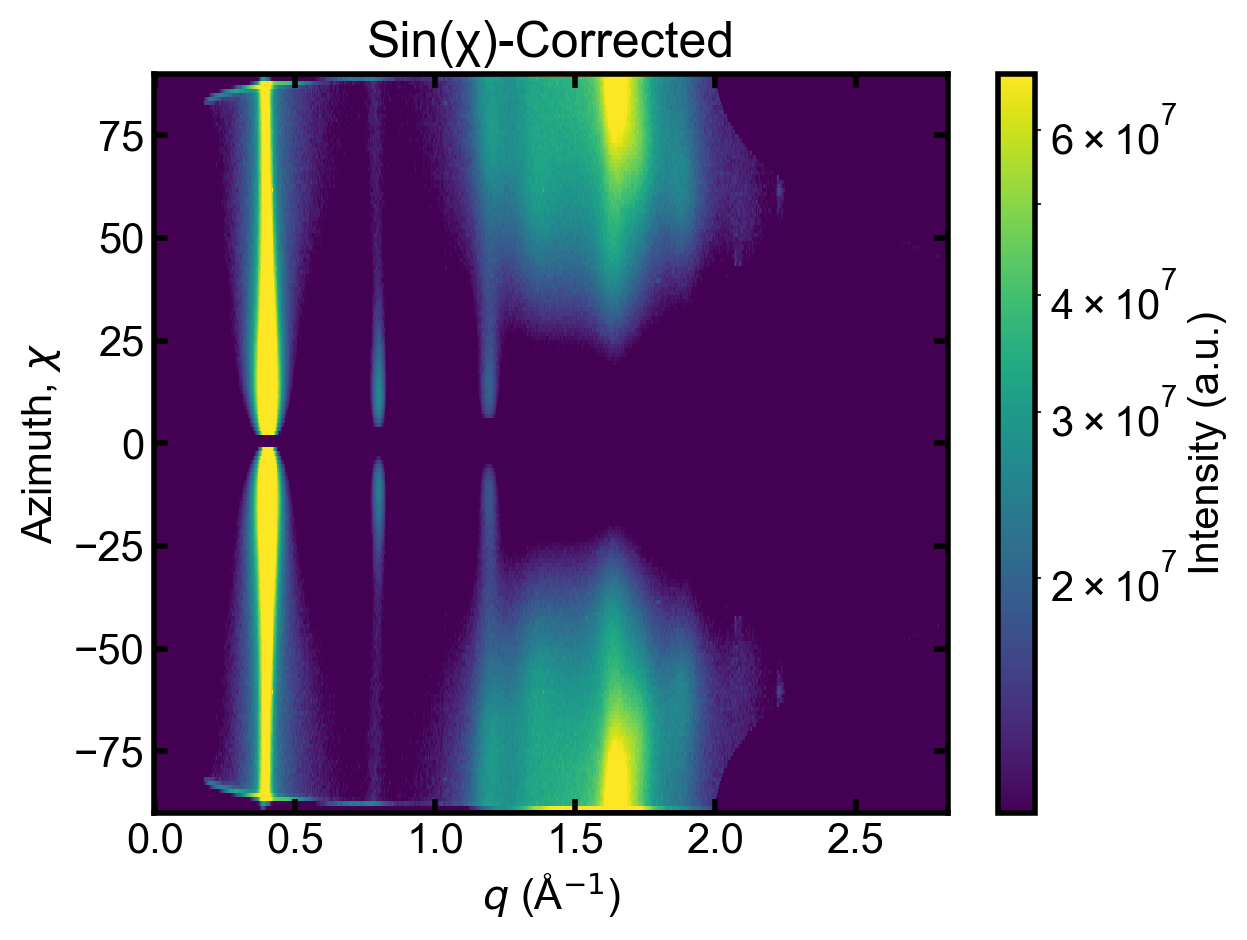

In [16]:
fig, ax = processor.plot_chiq(corrected_chiq, cmap='viridis')
plt.title('sin(χ)-Corrected')
plt.show()

# Here, you can play with the space group, lattice dimensions, angles, and Miller indices to index. Assuming you don't know orientation, the plot simply draws lines at the q-values where the resultant peaks are expected

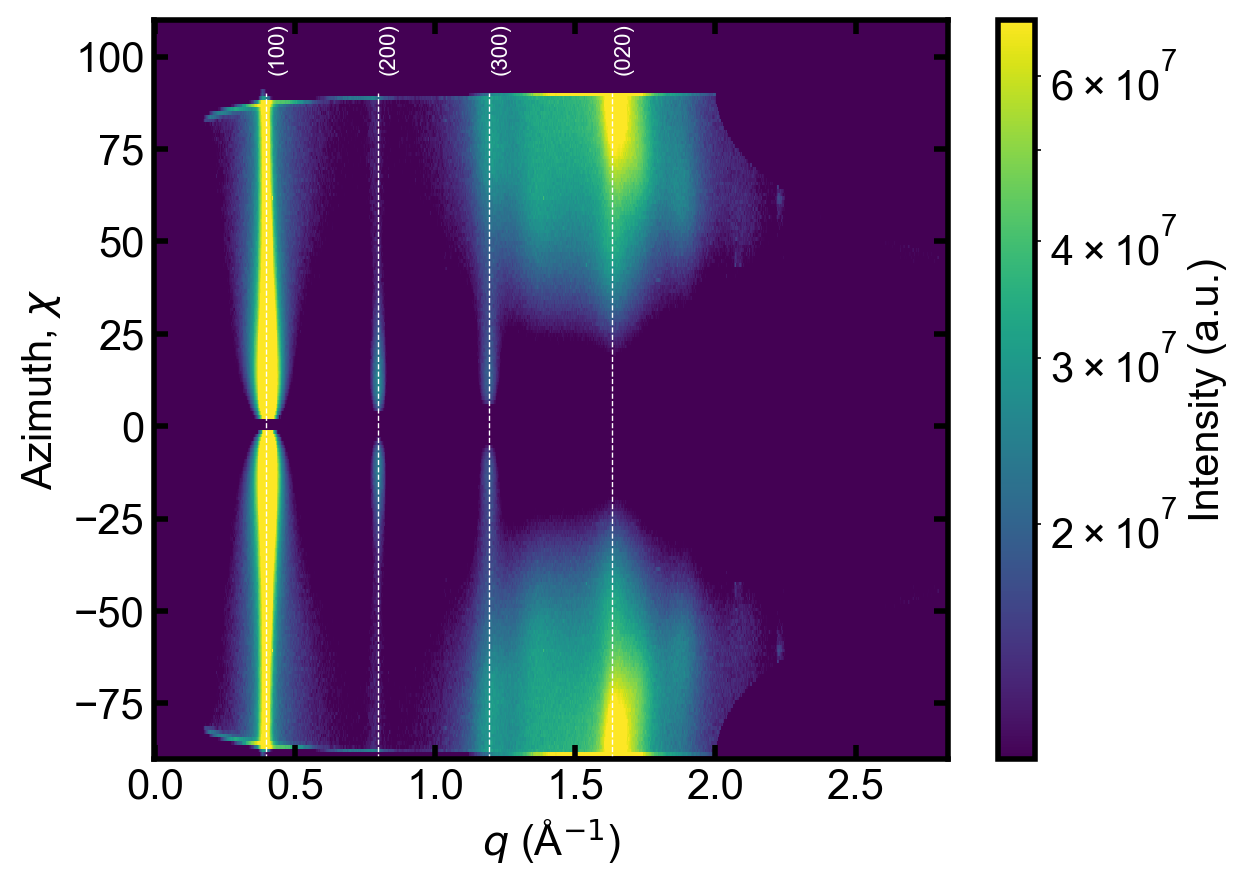

In [8]:
# Set display options for pandas DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Initialize custom Miller indices and other parameters
custom_miller_indices = [(1, 0, 0), (2, 0, 0), (3, 0, 0), (0, 2, 0)]
# custom_miller_indices = []
max_miller_index = 3
space_group = 'monoclinic'
a = 15.8
b = 7.7
c = 7.6
alpha = 90
beta = 90
gamma = 87

# Create an object of CrystalIndexingAnalyzer
analyzer = CrystalIndexingAnalyzer(space_group, a, b, c, alpha, beta, gamma)

# Call the compute_spacing method
spacing_table = analyzer.compute_spacing(custom_miller_indices, max_miller_index)

# Sort the DataFrame by QSpace_AngstromInverse in ascending order
spacing_table = spacing_table.sort_values(by='QSpace_AngstromInverse')
                         
fig, ax = processor.plot_chiq(corrected_chiq, cmap='viridis')

ax.set_ylim([-90, 110])  # change upper y-axis limit

# Get the maximum q value from the chiq DataFrame
max_q = corrected_chiq['q'].max()

texts = []
# Iterate over DataFrame rows
for idx, row in spacing_table.iterrows():
    # Get q value and Miller indices
    q = row['QSpace_AngstromInverse']
    h, k, l = row['h'], row['k'], row['l']
    
    # If q is greater than max_q, break the loop
    if q > max_q:
        break
    
    # Check if all Miller indices are non-negative
    if all(index >= 0 for index in [h, k, l]):
        # Add vertical line at q
        ax.plot([q, q], [-90, 90], color='white', linestyle='--', linewidth=0.5)  # line span from -90 to +90

        # Create label with plus-minus sign before non-zero Miller indices
        miller_indices_label = f'({int(abs(h))}{int(abs(k))}{int(abs(l))})'  # Concatenate the indices without commas

        # Add label with Miller indices
        texts.append(ax.text(q, 93.5, miller_indices_label, rotation=90, fontsize=8, color='white'))  # change color to white

# Adjust the position of text labels
adjust_text(texts, expand_text=(1.05, 1.2), expand_points=(1.05, 1.2), force_text=(0.75, 0.75), force_points=(0.75, 0.75))

# Show the plot
plt.show()

# If you can identify one of the Miller indices and specify it's orientation with a specific chi value, you can calculate where the other peaks will be relative to that one and attempt to index by comparison

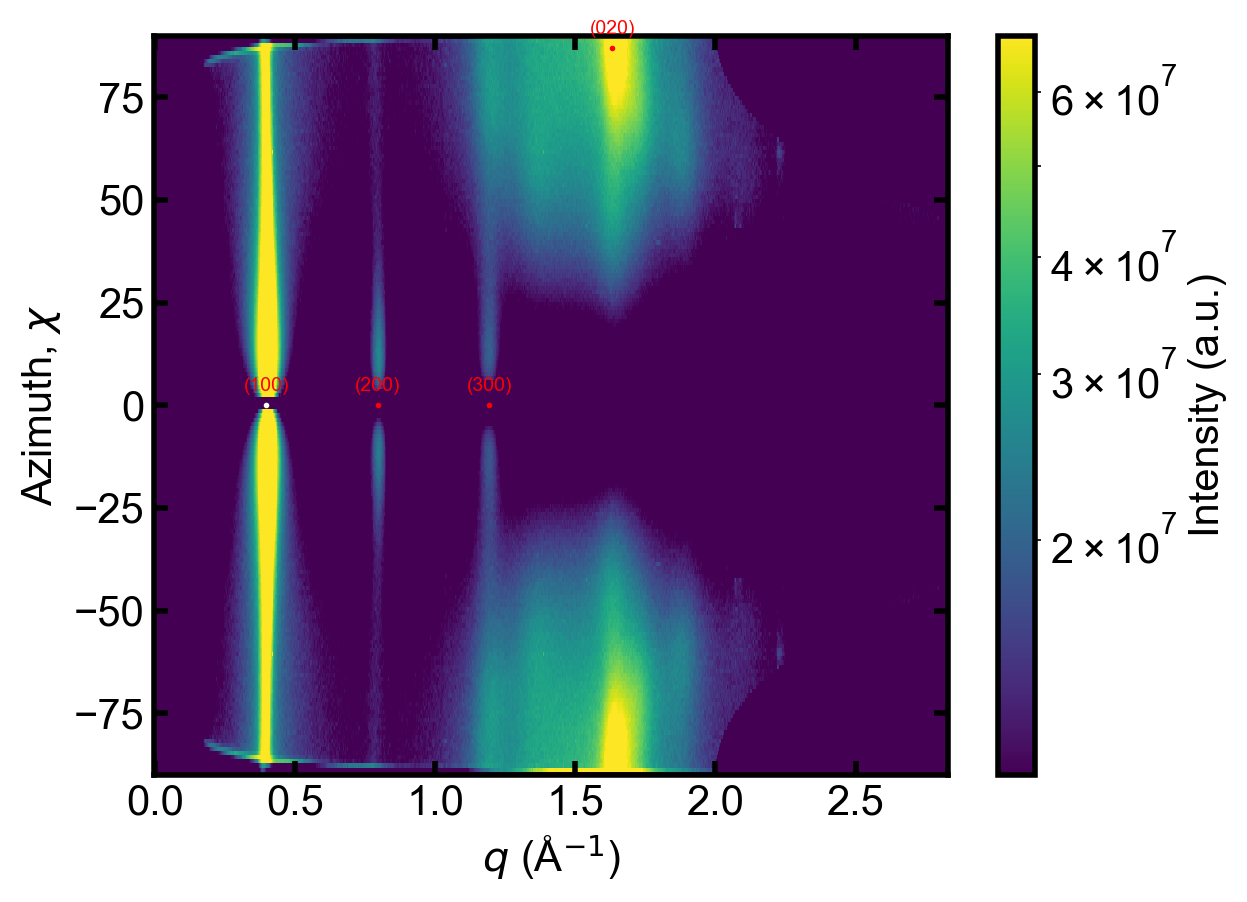

In [9]:
# User specified Miller indices (h1, k1, l1) and approximate chi value
h1, k1, l1 = 1, 0, 0 
approx_chi = 0

# Calculate 'Interplanar Angle' and 'Chi'
spacing_table = analyzer.calculate_interplanar_and_chi(spacing_table, h1, k1, l1, approx_chi = approx_chi)

# Generate the chi-q plot
fig, ax = processor.plot_chiq(corrected_chiq, cmap='viridis')

# Plot a circle at the chi and q of the user-specified Miller index
ref_q = spacing_table.loc[(spacing_table['h'] == h1) & (spacing_table['k'] == k1) & (spacing_table['l'] == l1), 'QSpace_AngstromInverse'].values[0]
ax.plot(ref_q, approx_chi, marker='.', markersize=2, color='white')

# Create a list to collect all the text objects for adjusting
texts = []

# Iterate through the rest of the list and plot the interplanar angles
for idx, row in spacing_table.iterrows():
    q = row['QSpace_AngstromInverse']
    chi = row['Chi']

    # If the current point is the reference point, skip it
    if row['h'] == h1 and row['k'] == k1 and row['l'] == l1:
        text = ax.annotate(f'({abs(int(h1))}{abs(int(k1))}{abs(int(l1))})', (ref_q, approx_chi), textcoords="offset points", xytext=(0,5), ha='center', color='red', fontsize=7)
        texts.append(text)
        continue

    # Plot a small dot for each other Miller index within the range of -90 to 90
    if -90 <= chi <= 90:
        ax.plot(q, chi, marker='.', markersize=2, color='red')
        text = ax.annotate(f'({abs(int(row["h"]))}{abs(int(row["k"]))}{abs(int(row["l"]))})', (q, chi), textcoords="offset points", xytext=(0,5), ha='center', color='red', fontsize=7)
        texts.append(text)

# Adjust the texts to minimize overlaps
# adjust_text(texts)

# Show the plot
plt.show()

# Below is the indexed P3HT

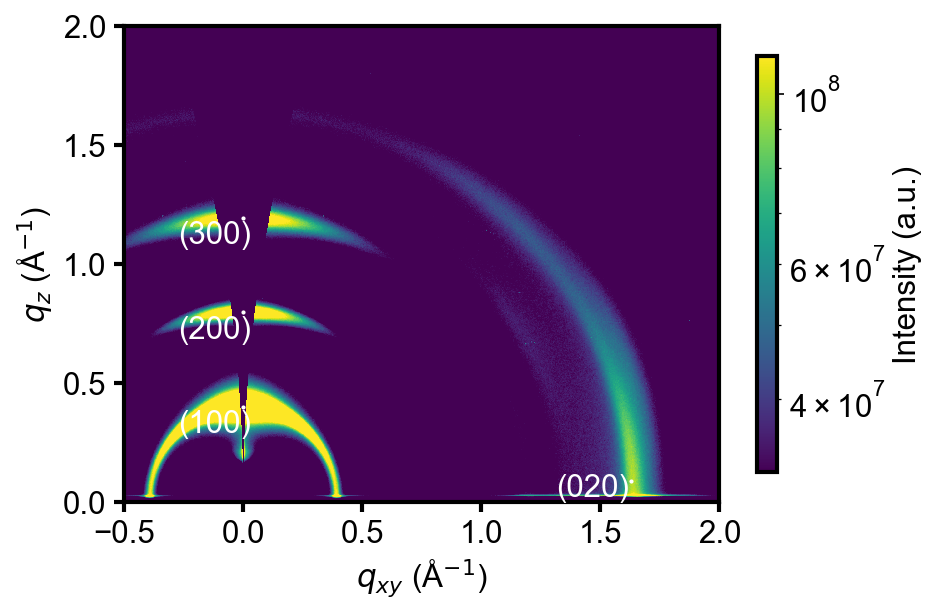

In [10]:
qxy_lower, qxy_upper = -0.5, 2 
qz_lower, qz_upper = 0, 2  

fig, ax = processor.plot_qzqxy(qzqxy, qxy_limits=(qxy_lower, qxy_upper), qz_limits=(qz_lower, qz_upper), cmap='viridis')

# # Add dashed circles
# circle_lower = Circle((0, 0), 1.6, color='white', fill=False, linestyle='dashed', linewidth=1)
# circle_upper = Circle((0, 0), q_uppers[-5], color='white', fill=False, linestyle='dashed', linewidth=1)

# ax.add_artist(circle_lower)
# ax.add_artist(circle_upper)

spacing_table = analyzer.compute_q_coordinates(spacing_table)

# Add your texts to a list instead of the plot
texts = []

# Plot a circle at the qxy and qz of the user-specified Miller index
ref_qxy = spacing_table.loc[(spacing_table['h'] == h1) & (spacing_table['k'] == k1) & (spacing_table['l'] == l1), 'qxy'].values[0]
ref_qz = spacing_table.loc[(spacing_table['h'] == h1) & (spacing_table['k'] == k1) & (spacing_table['l'] == l1), 'qz'].values[0]
ax.plot(ref_qxy, ref_qz, marker='.', markersize=2, color='white')
texts.append(ax.text(ref_qxy, ref_qz, f'({int(h1)}{int(k1)}{int(l1)})', ha='center', va='center', fontsize=15, color='white'))

for idx, row in spacing_table.iterrows():
    qxy = row['qxy']
    qz = row['qz']

    # Only plot points and labels if they're within the user-specified axis limits
    if qxy >= qxy_lower and qxy <= qxy_upper and qz >= qz_lower and qz <= qz_upper:
        # Skip the reference point
        if row['h'] == h1 and row['k'] == k1 and row['l'] == l1:
            continue
        ax.plot(qxy, qz, marker='.', markersize=2, color='white')
        texts.append(ax.text(qxy, qz, f'({abs(int(row["h"]))}{abs(int(row["k"]))}{abs(int(row["l"]))})', ha='center', va='center', fontsize=15, color='white'))

# Use adjust_text, which will take care of text overlapping
# adjust_text will stop after 500 iterations (default) or when no overlap will be detected
adjust_text(texts)

# Show the plot
plt.show()

fig.savefig('P3HT_GIWAXS_Example.tiff', bbox_inches = 'tight', pad_inches = 0.2, dpi = 300, transparent = False)

# You can also print the calculated values if they are of interest

In [11]:
spacing_table

,h,k,l,RealSpace_Angstroms,QSpace_AngstromInverse,Interplanar Angle,Chi,qxy,qz
0,1,0,0,15.800000,0.397670,0.0,0.0,0.00000,0.397670
1,2,0,0,7.900000,0.795340,0.0,0.0,0.00000,0.795340
2,3,0,0,5.266667,1.193010,0.0,0.0,0.00000,1.193010
3,0,2,0,3.850000,1.631996,87.0,87.0,1.62976,0.085412
4,0,-2,0,3.850000,1.631996,-93.0,-93.0,-1.62976,-0.085412
